In [1]:
import arrow
import datetime
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import os
import pandas as pd
import pickle
import xarray as xr

%matplotlib inline

In [2]:
plt.rcParams['font.size'] = 14

## The Grid ##

In [3]:
mesh = nc.Dataset('/home/sallen/MEOPAR/grid/mesh_mask201702.nc')
#mesh = nc.Dataset('../../../myResults/mesh_mask201702.nc')
gdepw = mesh.variables['gdepw_1d'][0]
bathy = nc.Dataset('/home/sallen/MEOPAR/grid/bathymetry_201702.nc')
#bathy = nc.Dataset('../../../myResults/bathymetry_201702.nc')
lats = bathy.variables['nav_lat'][:]
lons = bathy.variables['nav_lon'][:]
gdept = mesh.variables['gdept_1d'][0]
mesh.close()
bathy.close()

## Get the Data ##

In [4]:
def check_nan(ds):
    for j, index in enumerate(ds.index):
        if ds.transport[j] != ds.transport[j]:
            print (index)

In [10]:
Vic_to_PR_2015 = pd.read_csv('Vic_to_PR_2015_v3.csv', index_col=0, parse_dates=True)
print ('2015', Vic_to_PR_2015.transport.mean()/1000.); check_nan(Vic_to_PR_2015)
Vic_to_PR_2016 = pd.read_csv('Vic_to_PR_2016_v3.csv', index_col=0, parse_dates=True)
print ('2016', Vic_to_PR_2016.transport.mean()/1000.); check_nan(Vic_to_PR_2016)
Vic_to_PR_2017 = pd.read_csv('Vic_to_PR_2017_v3.csv', index_col=0, parse_dates=True)
print ('2017', Vic_to_PR_2017.transport.mean()/1000.); check_nan(Vic_to_PR_2017)
Vic_to_PR_2018 = pd.read_csv('Vic_to_PR_2018_v3.csv', index_col=0, parse_dates=True)
print ('2018', Vic_to_PR_2018.transport.mean()/1000.); check_nan(Vic_to_PR_2018)

2015 23.260960949873397
2016 23.975001880932254
2017 24.207005729799395
2018 23.225790335952308


In [11]:
Vic_to_GI_2015 = pd.read_csv('Vic_to_GI_2015_v3.csv', index_col=0, parse_dates=True)
print ('2015', Vic_to_GI_2015.transport.mean()/1000.); check_nan(Vic_to_GI_2015)
Vic_to_GI_2016 = pd.read_csv('Vic_to_GI_2016_v3.csv', index_col=0, parse_dates=True)
print ('2016', Vic_to_GI_2016.transport.mean()/1000.); check_nan(Vic_to_GI_2016)
Vic_to_GI_2017 = pd.read_csv('Vic_to_GI_2017_v3.csv', index_col=0, parse_dates=True)
print ('2017', Vic_to_GI_2017.transport.mean()/1000.); check_nan(Vic_to_GI_2017)
Vic_to_GI_2018 = pd.read_csv('Vic_to_GI_2018_v3.csv', index_col=0, parse_dates=True)
print ('2018', Vic_to_GI_2018.transport.mean()/1000.); check_nan(Vic_to_GI_2018)

2015 2.3577895169012235
2016 2.1163811267552917
2017 2.2539398004554654
2018 2.1046988741053925


In [12]:
PR_from_Vic_2015 = pd.read_csv('PR_from_Vic_2015_v3.csv', index_col=0, parse_dates=True)
print ('2015', PR_from_Vic_2015.transport.mean()/1000.); check_nan(PR_from_Vic_2015)
PR_from_Vic_2016 = pd.read_csv('PR_from_Vic_2016_v3.csv', index_col=0, parse_dates=True)
print ('2016', PR_from_Vic_2016.transport.mean()/1000.); check_nan(PR_from_Vic_2016)
PR_from_Vic_2017 = pd.read_csv('PR_from_Vic_2017_v3.csv', index_col=0, parse_dates=True)
print ('2017', PR_from_Vic_2017.transport.mean()/1000.); check_nan(PR_from_Vic_2017)
PR_from_Vic_2018 = pd.read_csv('PR_from_Vic_2018_v3.csv', index_col=0, parse_dates=True)
print ('2018', PR_from_Vic_2018.transport.mean()/1000.); check_nan(PR_from_Vic_2018)

2015 23.16950381813652
2016 23.663626086798104
2017 24.14207376302193
2018 23.627502032392805


In [13]:
GI_from_Vic_2015 = pd.read_csv('GI_from_Vic_2015_v3.csv', index_col=0, parse_dates=True)
print ('2015', GI_from_Vic_2015.transport.mean()/1000.); check_nan(GI_from_Vic_2015)
GI_from_Vic_2016 = pd.read_csv('GI_from_Vic_2016_v3.csv', index_col=0, parse_dates=True)
print ('2016', GI_from_Vic_2016.transport.mean()/1000.); check_nan(GI_from_Vic_2016)
GI_from_Vic_2017 = pd.read_csv('GI_from_Vic_2017_v3.csv', index_col=0, parse_dates=True)
print ('2017', GI_from_Vic_2017.transport.mean()/1000.); check_nan(GI_from_Vic_2017)
GI_from_Vic_2018 = pd.read_csv('GI_from_Vic_2018_v3.csv', index_col=0, parse_dates=True)
print ('2018', GI_from_Vic_2018.transport.mean()/1000.); check_nan(GI_from_Vic_2018)

2015 2.3915417662123404
2016 2.142756450834758
2017 2.2956708015863994
2018 2.229151399280443


In [14]:
PR_to_Vic_2015 = pd.read_csv('PR_to_Vic_2015_v3.csv', index_col=0, parse_dates=True)
print ('2015', PR_to_Vic_2015.transport.mean()/1000.); check_nan(PR_to_Vic_2015)
PR_to_Vic_2016 = pd.read_csv('PR_to_Vic_2016_v3.csv', index_col=0, parse_dates=True)
print ('2016', PR_to_Vic_2016.transport.mean()/1000.); check_nan(PR_to_Vic_2016)
PR_to_Vic_2017 = pd.read_csv('PR_to_Vic_2017_v3.csv', index_col=0, parse_dates=True)
print ('2017', PR_to_Vic_2017.transport.mean()/1000.); check_nan(PR_to_Vic_2017)
PR_to_Vic_2018 = pd.read_csv('PR_to_Vic_2018_v3.csv', index_col=0, parse_dates=True)
print ('2018', PR_to_Vic_2018.transport.mean()/1000.); check_nan(PR_to_Vic_2018)

2015 23.923387363466393
2016 24.191890364144417
2017 23.97470431375392
2018 23.17832074037491


In [15]:
GI_to_Vic_2015 = pd.read_csv('GI_to_Vic_2015_v3.csv', index_col=0, parse_dates=True)
print ('2015', GI_to_Vic_2015.transport.mean()/1000.); check_nan(GI_to_Vic_2015)
GI_to_Vic_2016 = pd.read_csv('GI_to_Vic_2016_v3.csv', index_col=0, parse_dates=True)
print ('2016', GI_to_Vic_2016.transport.mean()/1000.); check_nan(GI_to_Vic_2016)
GI_to_Vic_2017 = pd.read_csv('GI_to_Vic_2017_v3.csv', index_col=0, parse_dates=True)
print ('2017', GI_to_Vic_2017.transport.mean()/1000.); check_nan(GI_to_Vic_2017)
GI_to_Vic_2018 = pd.read_csv('GI_to_Vic_2018_v3.csv', index_col=0, parse_dates=True)
print ('2018', GI_to_Vic_2018.transport.mean()/1000.); check_nan(GI_to_Vic_2018)

2015 8.115411705285158
2016 7.9435802827760735
2017 8.291460551393374
2018 7.869992439194588


In [17]:
Vic_from_PR_2015 = pd.read_csv('Vic_from_PR_2015_v3.csv', index_col=0, parse_dates=True)
print ('2015', Vic_from_PR_2015.transport.mean()/1000.); check_nan(Vic_from_PR_2015)
Vic_from_PR_2016 = pd.read_csv('Vic_from_PR_2016_v3.csv', index_col=0, parse_dates=True)
print ('2016', Vic_from_PR_2016.transport.mean()/1000.); check_nan(Vic_from_PR_2016)
Vic_from_PR_2017 = pd.read_csv('Vic_from_PR_2017_v3.csv', index_col=0, parse_dates=True)
print ('2017', Vic_from_PR_2017.transport.mean()/1000.); check_nan(Vic_from_PR_2017)
Vic_from_PR_2018 = pd.read_csv('Vic_from_PR_2018_v3.csv', index_col=0, parse_dates=True)
print ('2018', Vic_from_PR_2018.transport.mean()/1000.); check_nan(Vic_from_PR_2018)

2015 24.050306657100922
2016 24.045999770340103
2017 23.990312937788694
2018 23.092685865657987


In [18]:
Vic_from_GI_2015 = pd.read_csv('Vic_from_GI_2015_v3.csv', index_col=0, parse_dates=True)
print ('2015', Vic_from_GI_2015.transport.mean()/1000.); check_nan(Vic_from_GI_2015)
Vic_from_GI_2016 = pd.read_csv('Vic_from_GI_2016_v3.csv', index_col=0, parse_dates=True)
print ('2016', Vic_from_GI_2016.transport.mean()/1000.); check_nan(Vic_from_GI_2016)
Vic_from_GI_2017 = pd.read_csv('Vic_from_GI_2017_v3.csv', index_col=0, parse_dates=True)
print ('2017', Vic_from_GI_2017.transport.mean()/1000.); check_nan(Vic_from_GI_2017)
Vic_from_GI_2018 = pd.read_csv('Vic_from_GI_2018_v3.csv', index_col=0, parse_dates=True)
print ('2018', Vic_from_GI_2018.transport.mean()/1000.); check_nan(Vic_from_GI_2018)

2015 7.975172729078504
2016 7.842403511699931
2017 8.194767702481254
2018 7.685422003213114


In [19]:
for ds in [Vic_to_PR_2015, Vic_to_PR_2016, Vic_to_PR_2017, Vic_to_PR_2018,
          Vic_to_GI_2015, Vic_to_GI_2016, Vic_to_GI_2017, Vic_to_GI_2018,
          PR_from_Vic_2015, PR_from_Vic_2016, PR_from_Vic_2017, PR_from_Vic_2018,
           GI_from_Vic_2015,GI_from_Vic_2016, GI_from_Vic_2017, GI_from_Vic_2018,
           PR_to_Vic_2015, PR_to_Vic_2016, PR_to_Vic_2017, PR_to_Vic_2018,
           GI_to_Vic_2015,GI_to_Vic_2016, GI_to_Vic_2017, GI_to_Vic_2018,
           Vic_from_PR_2015,Vic_from_PR_2016, Vic_from_PR_2017, Vic_from_PR_2018,
          Vic_from_GI_2015,Vic_from_GI_2016, Vic_from_GI_2017, Vic_from_GI_2018]:
    ds.tz_convert('UTC')

In [21]:
def combine_GI_PR(Vic_to_PR_2015, Vic_to_GI_2015):
    Vic_to_SoG_2015 = Vic_to_PR_2015.copy()
    for key in Vic_to_PR_2015.keys():
        if key == 'transport':
            Vic_to_SoG_2015.transport = Vic_to_PR_2015.transport + Vic_to_GI_2015.transport
        else:
            Vic_to_SoG_2015[key] = ((Vic_to_PR_2015[key] * Vic_to_PR_2015.transport 
                                + Vic_to_GI_2015[key] * Vic_to_GI_2015.transport) /
                            (Vic_to_PR_2015.transport + Vic_to_GI_2015.transport))
    return Vic_to_SoG_2015

In [22]:
Vic_to_SoG_2015 = combine_GI_PR(Vic_to_PR_2015, Vic_to_GI_2015)
SoG_from_Vic_2015 = combine_GI_PR(PR_from_Vic_2015, GI_from_Vic_2015)

In [23]:
Vic_to_SoG_2016 = combine_GI_PR(Vic_to_PR_2016, Vic_to_GI_2016)
SoG_from_Vic_2016 = combine_GI_PR(PR_from_Vic_2016, GI_from_Vic_2016)

In [24]:
Vic_to_SoG_2017 = combine_GI_PR(Vic_to_PR_2017, Vic_to_GI_2017)
SoG_from_Vic_2017 = combine_GI_PR(PR_from_Vic_2017, GI_from_Vic_2017)

In [25]:
Vic_to_SoG_2018 = combine_GI_PR(Vic_to_PR_2018, Vic_to_GI_2018)
SoG_from_Vic_2018 = combine_GI_PR(PR_from_Vic_2018, GI_from_Vic_2018)

In [26]:
SoG_to_Vic_2015 = combine_GI_PR(PR_to_Vic_2015, GI_to_Vic_2015)
Vic_from_SoG_2015 = combine_GI_PR(Vic_from_PR_2015, Vic_from_GI_2015)

In [27]:
SoG_to_Vic_2016 = combine_GI_PR(PR_to_Vic_2016, GI_to_Vic_2016)
Vic_from_SoG_2016 = combine_GI_PR(Vic_from_PR_2016, Vic_from_GI_2016)

In [28]:
SoG_to_Vic_2017 = combine_GI_PR(PR_to_Vic_2017, GI_to_Vic_2017)
Vic_from_SoG_2017 = combine_GI_PR(Vic_from_PR_2017, Vic_from_GI_2017)

In [29]:
SoG_to_Vic_2018 = combine_GI_PR(PR_to_Vic_2018, GI_to_Vic_2018)
Vic_from_SoG_2018 = combine_GI_PR(Vic_from_PR_2018, Vic_from_GI_2018)

/home/sallen/anaconda/envs/py37/lib/python3.7/site-packages/pandas/core/arrays/datetimes.py:1269: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,
/home/sallen/anaconda/envs/py37/lib/python3.7/site-packages/pandas/core/arrays/datetimes.py:1269: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


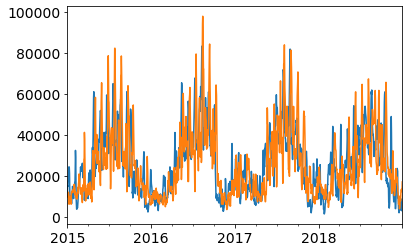

In [30]:
Vic_to_SoG = pd.concat([Vic_to_SoG_2015, Vic_to_SoG_2016, Vic_to_SoG_2017, Vic_to_SoG_2018])
SoG_from_Vic = pd.concat([SoG_from_Vic_2015, SoG_from_Vic_2016, SoG_from_Vic_2017, SoG_from_Vic_2018])
Vic_to_SoG.transport.plot()
SoG_from_Vic.transport.plot();

/home/sallen/anaconda/envs/py37/lib/python3.7/site-packages/pandas/core/arrays/datetimes.py:1269: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


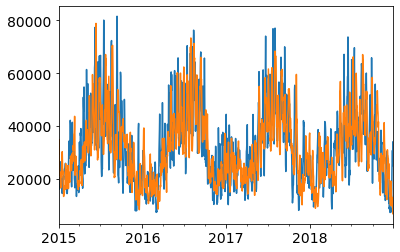

In [31]:
SoG_to_Vic = pd.concat([SoG_to_Vic_2015, SoG_to_Vic_2016, SoG_to_Vic_2017, SoG_to_Vic_2018])
Vic_from_SoG = pd.concat([Vic_from_SoG_2015, Vic_from_SoG_2016, Vic_from_SoG_2017, Vic_from_SoG_2018])
SoG_to_Vic.transport.plot()
Vic_from_SoG.transport.plot();

In [32]:
def correct_time(Vic_to_SoG_2015, basic, factor):
    corrected_time =np.empty_like(np.array(Vic_to_SoG_2015.index))
    for i, index in enumerate(Vic_to_SoG_2015.index):
        corrected_time[i] = index + datetime.timedelta(days=basic+Vic_to_SoG_2015.final_age[i]*factor)
    Vic_to_SoG_2015['correct_time'] = corrected_time
    return (Vic_to_SoG_2015)

In [33]:
def merge(df, df2):
   
    nidx = df.index
    ndf = df.set_index('correct_time')
    ndf.tz_localize('UTC')
    oidx = ndf.index

    step1 = ndf.reindex(oidx.union(nidx))
    step2 = step1.set_index(pd.to_datetime(step1.index, utc='True'))
    step3 = step2.sort_index()
    step4 = step3.interpolate(axis=0)
    res = step4.reindex(nidx)
   
    nidx = df2.index
    ndf2 = df2.set_index('correct_time')
    ndf2.tz_localize('UTC')
    oidx = ndf2.index
    
    step1 = ndf2.reindex(oidx.union(nidx))
    step2 = step1.set_index(pd.to_datetime(step1.index, utc='True'))
    step3 = step2.sort_index()
    step4 = step3.interpolate(axis=0)
    res2 = step4.reindex(nidx)
    
    corr = (res.transport.corr(res2.transport))
    return res, res2, 0.5*(res.transport + res2.transport), corr


## Shallow Flux ##

In [34]:
corr = np.zeros((21, 21))
for j, factor in enumerate(np.arange(0., 1.0, 0.05)):
    cb = 3 - 21/1.9*factor
    for i, basic in enumerate(cb+np.arange(0.3-0.4, 0.3+0.4, 0.04)):
        df1 = correct_time(Vic_from_SoG, basic=-basic, factor=-factor)
        df2 = correct_time(SoG_to_Vic, basic=basic, factor=factor)
        fluxfrom, fluxto, shallow_flux, corr[i,j] = merge(df1, df2)
        if corr[i,j] > 0.726:
            print (basic, factor, corr[i, j])

/home/sallen/anaconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Converting timezone-aware DatetimeArray to timezone-naive ndarray with 'datetime64[ns]' dtype. In the future, this will return an ndarray with 'object' dtype where each element is a 'pandas.Timestamp' with the correct 'tz'.
	To accept the future behavior, pass 'dtype=object'.
	To keep the old behavior, pass 'dtype="datetime64[ns]"'.
  """
/home/sallen/anaconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  after removing the cwd from sys.path.
/home/sallen/anaconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Converting timezone-aware DatetimeArray to timezone-naive ndarray with 'datetime64[ns]' dtype. In the future, this will return an ndarray with 'object' dtype where each element is a 'pandas.Timestamp' with the correct 'tz'.
	To

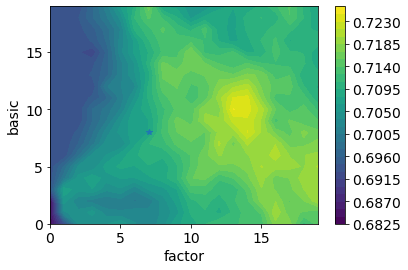

In [137]:
# Shallow
plt.contourf(corr[:20, :20], 30)
plt.colorbar()
plt.xlabel('factor')
plt.ylabel('basic')
plt.plot(7, 8, '*');

/home/sallen/anaconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Converting timezone-aware DatetimeArray to timezone-naive ndarray with 'datetime64[ns]' dtype. In the future, this will return an ndarray with 'object' dtype where each element is a 'pandas.Timestamp' with the correct 'tz'.
	To accept the future behavior, pass 'dtype=object'.
	To keep the old behavior, pass 'dtype="datetime64[ns]"'.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/sallen/anaconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  after removing the cwd from sys.path.
/home/sallen/anaconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Converting timezone-aware DatetimeArray to timezone-naive ndarray with 'datetime64[ns]' dtype. In the future, this will return an ndarray with 'object'

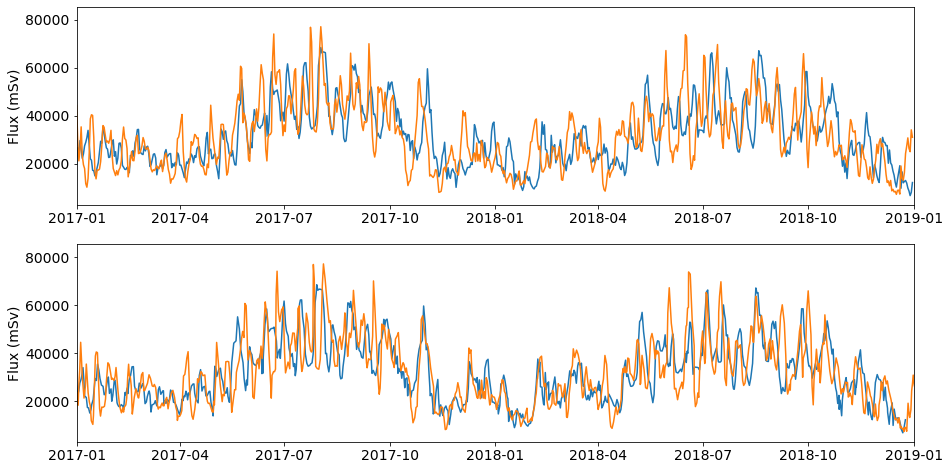

In [35]:
fig, axs = plt.subplots(2, 1, figsize=(15, 8))
basic, factor = -4.125, 0.67
SoG_to_Vic_corr = correct_time(SoG_to_Vic, basic=basic, factor=factor)
Vic_from_SoG_corr = correct_time(Vic_from_SoG, basic=-basic, factor=-factor)
axs[0].plot(Vic_from_SoG_corr.index, Vic_from_SoG_corr.transport)
axs[1].plot(Vic_from_SoG_corr.correct_time, Vic_from_SoG_corr.transport)
axs[0].plot(SoG_to_Vic_corr.index, SoG_to_Vic_corr.transport)
axs[1].plot(SoG_to_Vic_corr.correct_time, SoG_to_Vic_corr.transport)
for axi in axs:
    axi.set_ylabel('Flux (mSv)')
    axi.set_xlim(datetime.datetime(2017, 1, 1), datetime.datetime(2019, 1, 1));

/home/sallen/anaconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Converting timezone-aware DatetimeArray to timezone-naive ndarray with 'datetime64[ns]' dtype. In the future, this will return an ndarray with 'object' dtype where each element is a 'pandas.Timestamp' with the correct 'tz'.
	To accept the future behavior, pass 'dtype=object'.
	To keep the old behavior, pass 'dtype="datetime64[ns]"'.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/sallen/anaconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  after removing the cwd from sys.path.
/home/sallen/anaconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Converting timezone-aware DatetimeArray to timezone-naive ndarray with 'datetime64[ns]' dtype. In the future, this will return an ndarray with 'object'

2015-01-01 00:00:00+00:00             NaN
2015-01-02 00:00:00+00:00             NaN
2015-01-03 00:00:00+00:00             NaN
2015-01-04 00:00:00+00:00             NaN
2015-01-05 00:00:00+00:00             NaN
                                 ...     
2018-12-27 00:00:00+00:00    12630.883591
2018-12-28 00:00:00+00:00    14271.553046
2018-12-29 00:00:00+00:00    13381.229648
2018-12-30 00:00:00+00:00    16173.757165
2018-12-31 00:00:00+00:00    18926.604001
Name: transport, Length: 1461, dtype: float64


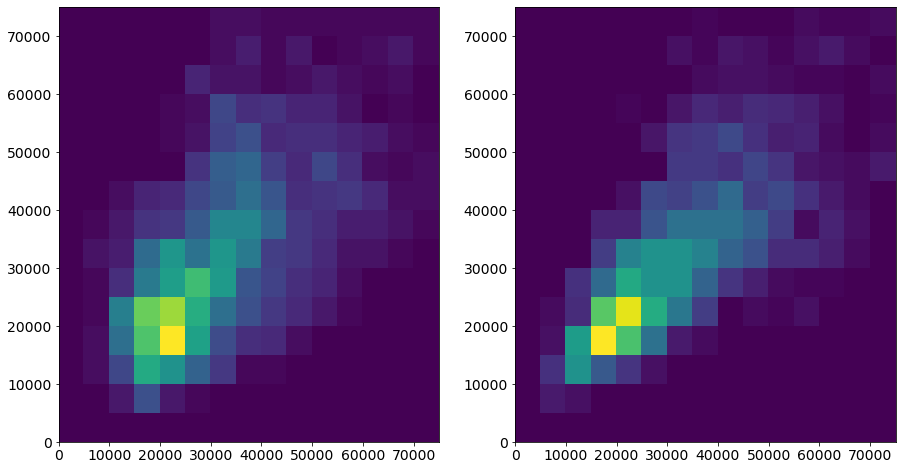

In [36]:
fig, axs = plt.subplots(1, 2, figsize=(15, 8))
basic, factor = -4.125, 0.67
SoG_to_Vic_corr = correct_time(SoG_to_Vic, basic=basic, factor=factor)
Vic_from_SoG_corr = correct_time(Vic_from_SoG, basic=-basic, factor=-factor)
res, res2, shallow_flux, corr = merge(SoG_to_Vic_corr, Vic_from_SoG_corr)
axs[0].hist2d(Vic_from_SoG.transport, SoG_to_Vic.transport, np.arange(0, 80000, 5000));
axs[1].hist2d(res.transport, res2.transport, np.arange(0, 80000, 5000));
print (shallow_flux)

## Deep Fluxes ##

In [37]:
corr = np.zeros((21, 21))
for j, factor in enumerate(np.arange(0.6+0.1, 0.6+0.4+0.1, 0.02)):
    cb = 3 - 21/1.9*factor
    for i, basic in enumerate(cb+np.arange(-2.1-0.2, -2.1+0.2, 0.02)):
        df1 = correct_time(SoG_from_Vic, basic=-basic, factor=-factor)
        df2 = correct_time(Vic_to_SoG, basic=basic, factor=factor)
        fluxfrom, fluxto, deep_flux, corr[i,j] = merge(df1, df2)
        if corr[i,j] > 0.861:
            print (i, j, basic, factor, corr[i, j])

/home/sallen/anaconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Converting timezone-aware DatetimeArray to timezone-naive ndarray with 'datetime64[ns]' dtype. In the future, this will return an ndarray with 'object' dtype where each element is a 'pandas.Timestamp' with the correct 'tz'.
	To accept the future behavior, pass 'dtype=object'.
	To keep the old behavior, pass 'dtype="datetime64[ns]"'.
  """
/home/sallen/anaconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  after removing the cwd from sys.path.
/home/sallen/anaconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Converting timezone-aware DatetimeArray to timezone-naive ndarray with 'datetime64[ns]' dtype. In the future, this will return an ndarray with 'object' dtype where each element is a 'pandas.Timestamp' with the correct 'tz'.
	To

12 11 -9.22842105263158 0.9200000000000002 0.8610388849324494
6 12 -9.569473684210527 0.9400000000000002 0.8612420917557269
8 12 -9.529473684210528 0.9400000000000002 0.8614306496085425
5 13 -9.810526315789474 0.9600000000000002 0.861181540877044
6 13 -9.790526315789474 0.9600000000000002 0.8611637320184424


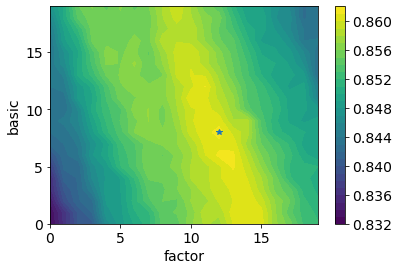

In [38]:
# Deep
plt.contourf(corr[:20, :20], 30)
plt.colorbar()
plt.xlabel('factor')
plt.ylabel('basic')
plt.plot(12, 8, '*');

/home/sallen/anaconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Converting timezone-aware DatetimeArray to timezone-naive ndarray with 'datetime64[ns]' dtype. In the future, this will return an ndarray with 'object' dtype where each element is a 'pandas.Timestamp' with the correct 'tz'.
	To accept the future behavior, pass 'dtype=object'.
	To keep the old behavior, pass 'dtype="datetime64[ns]"'.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/sallen/anaconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  after removing the cwd from sys.path.
/home/sallen/anaconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Converting timezone-aware DatetimeArray to timezone-naive ndarray with 'datetime64[ns]' dtype. In the future, this will return an ndarray with 'object'

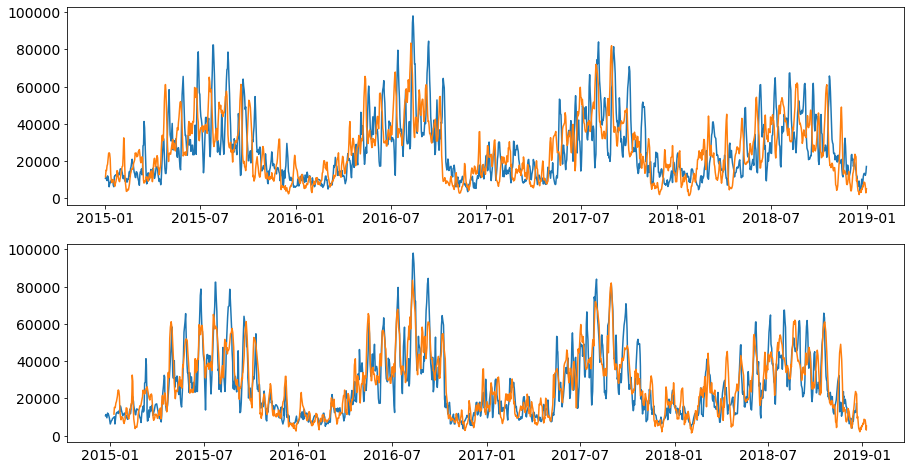

In [39]:
fig, axs = plt.subplots(2, 1, figsize=(15, 8))
basic, factor = -9.53, 0.94
Vic_to_SoG_corr = correct_time(Vic_to_SoG, basic=basic, factor=factor)
SoG_from_Vic_corr = correct_time(SoG_from_Vic, basic=-basic, factor=-factor)
axs[0].plot(SoG_from_Vic_corr.index, SoG_from_Vic_corr.transport)
axs[1].plot(SoG_from_Vic_corr.correct_time, SoG_from_Vic_corr.transport)
axs[0].plot(Vic_to_SoG_corr.index, Vic_to_SoG_corr.transport)
axs[1].plot(Vic_to_SoG_corr.correct_time, Vic_to_SoG_corr.transport)

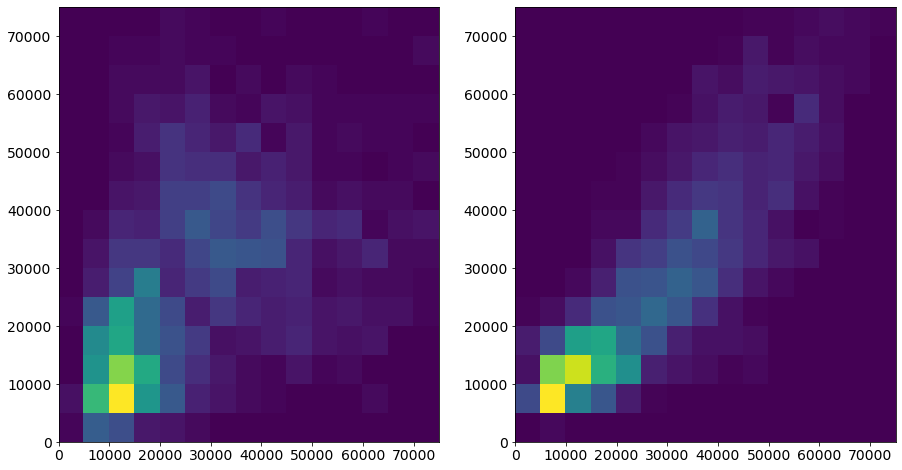

In [40]:
fig, axs = plt.subplots(1, 2, figsize=(15, 8))

res, res2, deep_flux, corr = merge(Vic_to_SoG_corr, SoG_from_Vic_corr)
axs[0].hist2d(SoG_from_Vic.transport, Vic_to_SoG.transport, np.arange(0, 80000, 5000));
axs[1].hist2d(res.transport, res2.transport, np.arange(0, 80000, 5000));

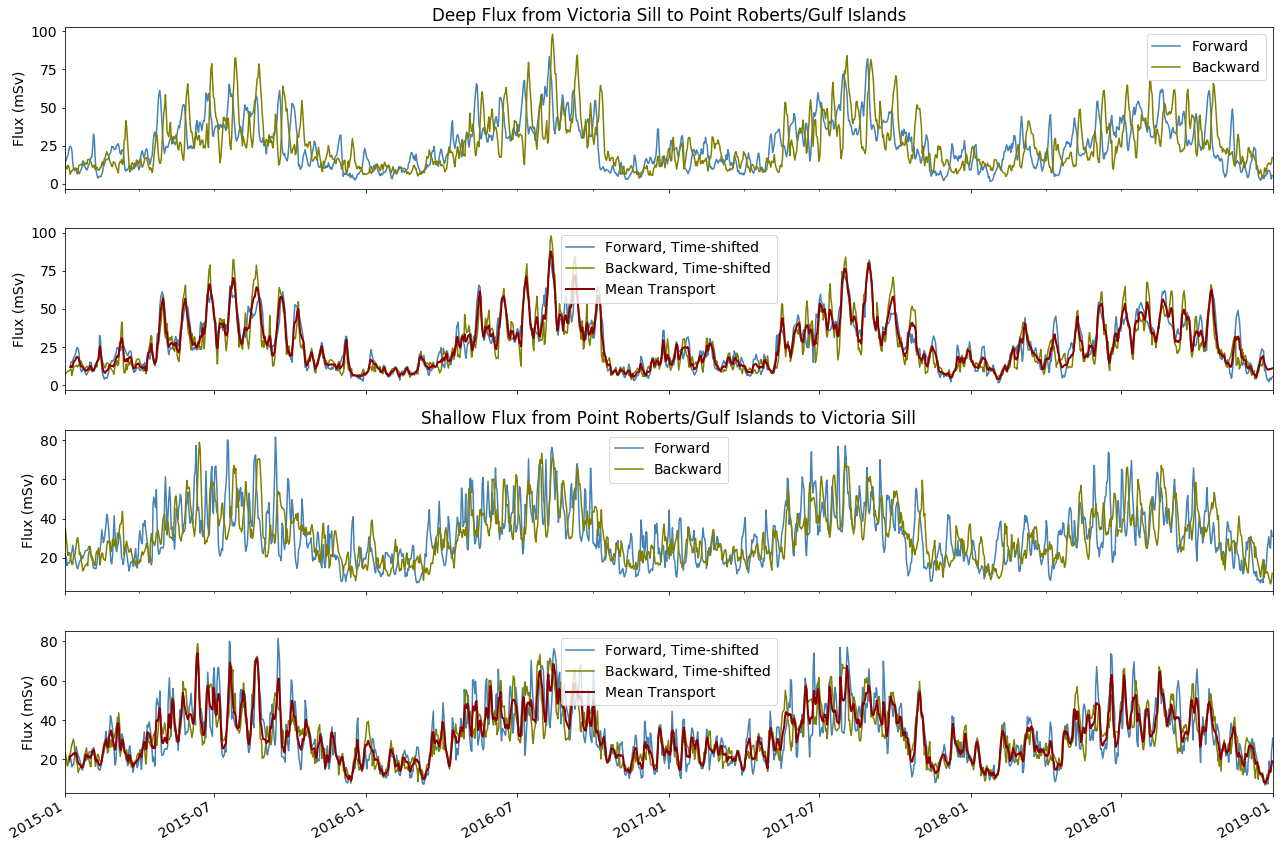

In [41]:
fig, ax = plt.subplots(4, 1, figsize=(18, 12))

ax[0].set_title("Deep Flux from Victoria Sill to Point Roberts/Gulf Islands")
(Vic_to_SoG.transport/1000.).plot(ax=ax[0], label='Forward', color='steelblue')
(SoG_from_Vic.transport/1000.).plot(ax=ax[0], label='Backward', color='olive')

ax[1].plot(Vic_to_SoG.correct_time, Vic_to_SoG.transport/1000., color='steelblue', label='Forward, Time-shifted')
ax[1].plot(SoG_from_Vic.correct_time, SoG_from_Vic.transport/1000., color='olive', label='Backward, Time-shifted')
(deep_flux/1000.).plot(ax=ax[1], color='darkred', linewidth=2, label='Mean Transport')


ax[2].set_title("Shallow Flux from Point Roberts/Gulf Islands to Victoria Sill")
(SoG_to_Vic.transport/1000.).plot(ax=ax[2], label='Forward', color='steelblue')
(Vic_from_SoG.transport/1000.).plot(ax=ax[2], label='Backward', color='olive')


ax[3].plot(SoG_to_Vic.correct_time, SoG_to_Vic.transport/1000., color='steelblue', label='Forward, Time-shifted')
ax[3].plot(Vic_from_SoG.correct_time, Vic_from_SoG.transport/1000., color='olive', label='Backward, Time-shifted')
(shallow_flux/1000.).plot(ax=ax[3], color='darkred', linewidth=2, label='Mean Transport')


for axi in ax:
    axi.set_ylabel('Flux (mSv)')
    axi.set_xlim(datetime.datetime(2015, 1, 1), datetime.datetime(2019, 1, 1))
    axi.legend(loc='best')
    
for axi in [ax[0], ax[1], ax[2]]:
    axi.tick_params(
        axis='x', which='both', labelbottom=False)

fig.tight_layout()
fig.savefig('/home/sallen/MEOPAR/estuarine_flux_paper/transports_supp.pdf')

## Depths ##

In [51]:
print ('to PR', 0.5*SoG_to_Vic.init_depth.mean()
       + 0.5*SoG_to_Vic.final_depth.mean())
print ('to PR', SoG_to_Vic.init_depth.mean(),
       SoG_to_Vic.final_depth.mean())
print ('to VS', 0.5*Vic_to_SoG.init_depth.mean()
       + 0.5*Vic_to_SoG.final_depth.mean())

to PR -25.454016748604516
to PR -27.991434754437062 -22.916598742771967
to VS -74.33885697956717


## Calculation of Tides moved to "Calculate Tides" ##
Here just read them

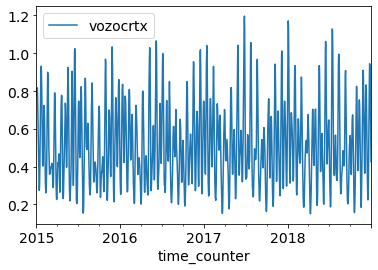

In [52]:
low_pass_tide = pd.read_csv('low_pass_tide.csv', index_col=0)
low_pass_tide.index = pd.to_datetime(low_pass_tide.index, format="%Y-%m-%d")
low_pass_tide.plot()

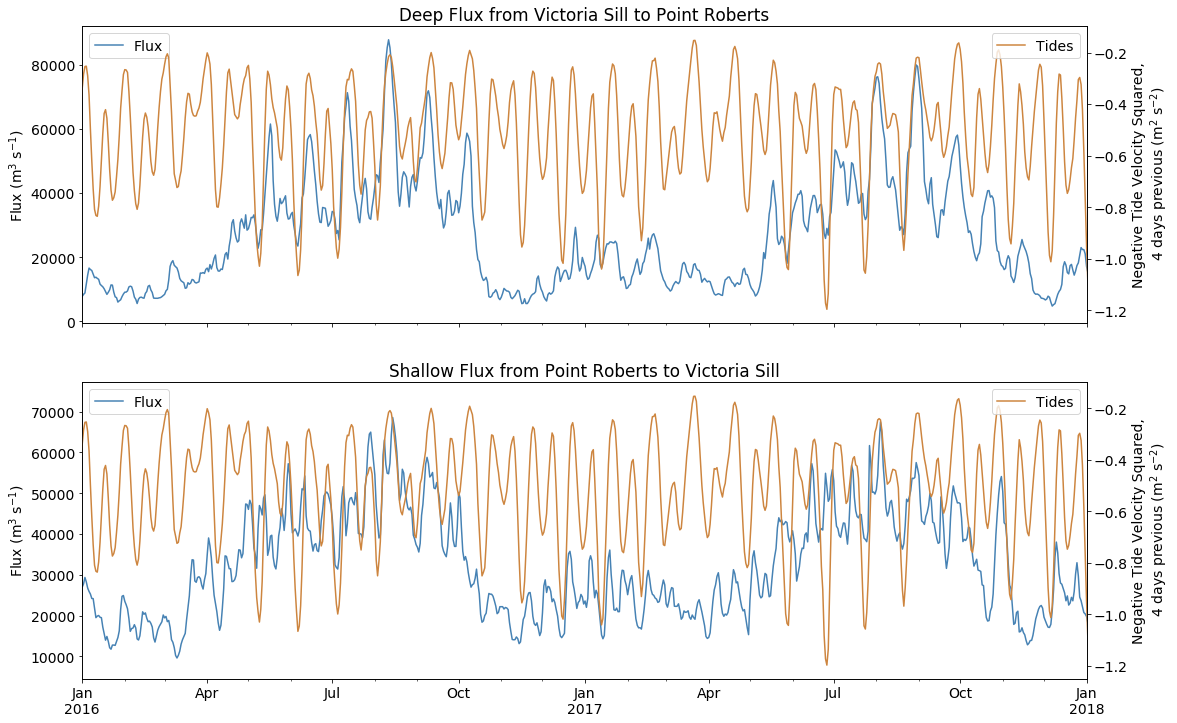

In [57]:
fig, ax = plt.subplots(2, 1, figsize=(18, 12))
ax[0].set_title("Deep Flux from Victoria Sill to Point Roberts")
deep_flux.plot(ax=ax[0], y='transport', label="Flux", color='steelblue')
ax[1].set_title("Shallow Flux from Point Roberts to Victoria Sill")
shallow_flux.plot(ax=ax[1], y='transport', label="Flux", color='steelblue')
for ax in [ax[0], ax[1]]:
    ax2 = ax.twinx()
    ax.set_ylabel('Flux (m$^3$ s$^{-1}$)')
    (-low_pass_tide.shift(0)).plot(ax=ax2, y='vozocrtx', color = 'peru', label='Tides')
    ax.set_xlim(datetime.datetime(2016, 1, 1), datetime.datetime(2018, 1, 1))
    ax.legend(loc='upper left')
    ax2.legend(loc='upper right')
    ax2.set_ylabel('Negative Tide Velocity Squared,\n 4 days previous (m$^2$ s$^{-2}$)')

## Summer Deep Water Variability ##

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(14, 5))
ax2 = ax.twinx()
lag = -3
ii, jj = 190, 300
ax.plot(range(ii, jj),fullsouth_transport['transport'][ii+lag:jj+lag])
ax2.plot(range(ii, jj), -low_pass_tide['uVelocity'][ii:jj], 'r')

## Spring Deep Water Variability ##

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(14, 5))
ax2 = ax.twinx()
lag = -3
ii, jj = 100, 190
ax.plot(range(ii, jj),fullsouth_transport['transport'][ii+lag:jj+lag])
ax2.plot(range(ii, jj), -low_pass_tide['uVelocity'][ii:jj], 'r')

## Winter Deep Water Variability : note change in lag

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(14, 5))
ax2 = ax.twinx()
lag = -5
ii, jj = 0-lag, 100
ax.plot(range(ii, jj),fullsouth_transport['transport'][ii+lag:jj+lag])
ax2.plot(range(ii, jj), -low_pass_tide['uVelocity'][ii:jj], 'r')

# Impact of Density Difference #

In [58]:
sigma = pd.read_csv('sigma_2015_201806.csv', index_col=0)
m2015 = sigma.south - sigma.north
m2015.index = pd.to_datetime(m2015.index, format="%Y-%m-%d")

In [59]:
sigma = pd.read_csv('sigma_2016_201806.csv', index_col=0)
m2016 = sigma.south - sigma.north
m2016.index = pd.to_datetime(m2016.index, format="%Y-%m-%d")

In [60]:
sigma = pd.read_csv('sigma_2017_201806.csv', index_col=0)
m2017 = sigma.south - sigma.north
m2017.index = pd.to_datetime(m2017.index, format="%Y-%m-%d")

In [61]:
sigma = pd.read_csv('sigma_2018_201806.csv', index_col=0)
m2018 = sigma.south - sigma.north
m2018.index = pd.to_datetime(m2018.index, format="%Y-%m-%d")

/home/sallen/anaconda/envs/py37/lib/python3.7/site-packages/pandas/core/arrays/datetimes.py:1269: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,
/home/sallen/anaconda/envs/py37/lib/python3.7/site-packages/pandas/core/arrays/datetimes.py:1269: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,
/home/sallen/anaconda/envs/py37/lib/python3.7/site-packages/pandas/core/arrays/datetimes.py:1269: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


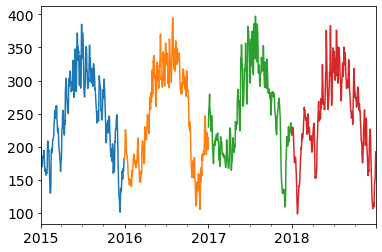

In [62]:
m2015.plot()
m2016.plot()
m2017.plot()
m2018.plot()

In [92]:
densitydiff = pd.concat([m2015, m2016, m2017, m2018])
densityforcing = np.sqrt(goverrho*densitydiff[:])

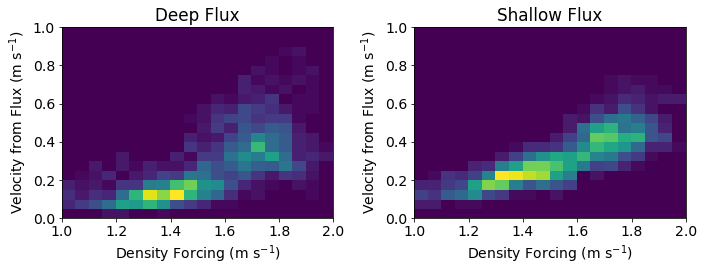

In [100]:
goverrho=9.81/1000.
depthwidth = 10*10e3
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[1].hist2d(densityforcing, shallow_flux[:]/depthwidth, range=[[0, 2], [0, 2]], bins=40)
axs[0].hist2d(densityforcing, deep_flux[:]/depthwidth, range=[[0, 2], [0, 2]], bins=40)
axs[0].set_title("Deep Flux")
axs[1].set_title("Shallow Flux")
for ax in axs:
    ax.set_xlabel('Density Forcing (m s$^{-1}$)')
    ax.set_ylabel('Velocity from Flux (m s$^{-1}$)')
    ax.set_xlim(1, 2)
    ax.set_ylim(0, 1)
fig.tight_layout()
fig.savefig('/home/sallen/MEOPAR/estuarine_flux_paper/density_forcing.pdf')
fig.savefig('/home/sallen/MEOPAR/estuarine_flux_paper/density_forcing.png')

/home/sallen/anaconda/envs/py37/lib/python3.7/site-packages/pandas/core/arrays/datetimes.py:1269: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


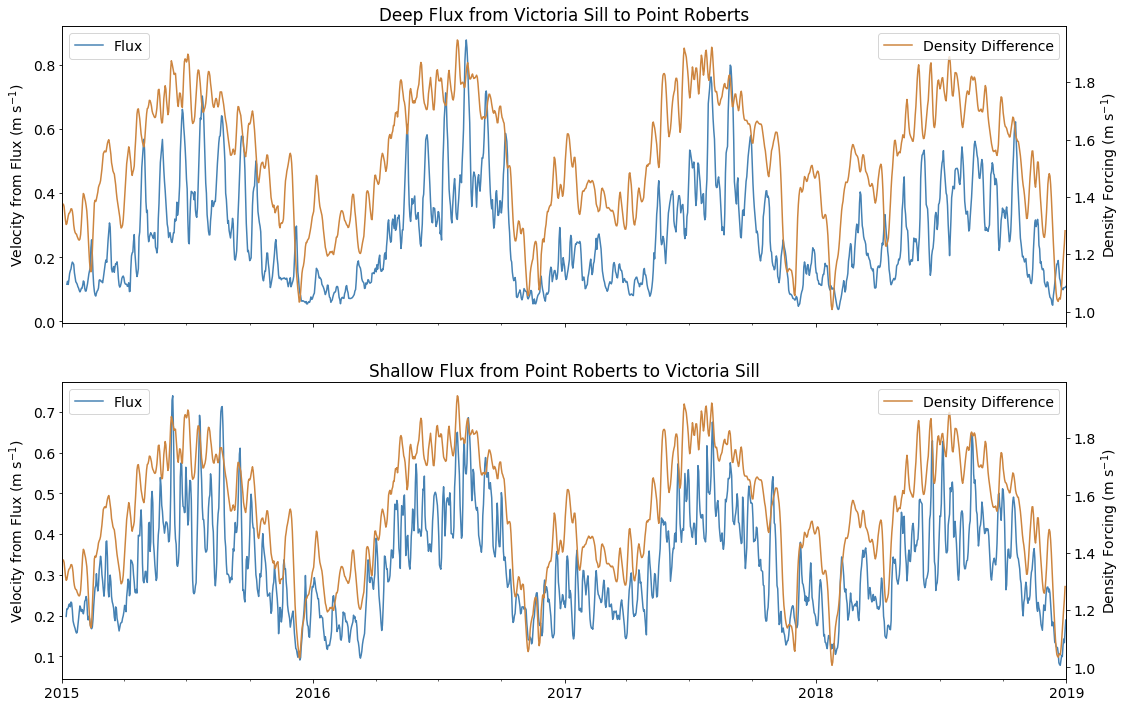

In [102]:
fig, ax = plt.subplots(2, 1, figsize=(18, 12))

ax[0].set_title("Deep Flux from Victoria Sill to Point Roberts")
(deep_flux/depthwidth).plot(ax=ax[0], y='transport', label="Flux", color='steelblue')

ax[1].set_title("Shallow Flux from Point Roberts to Victoria Sill")
(shallow_flux/depthwidth).plot(ax=ax[1], y='transport', label="Flux", color='steelblue')

for ax in [ax[0], ax[1]]:
    ax2 = ax.twinx()
    ax.set_ylabel('Velocity from Flux (m s$^{-1}$)')
    density_line = densityforcing.rolling(window=4, center=True).mean().plot(
        ax=ax2, label='Density Difference',  color = 'peru')
    ax.set_xlim(datetime.datetime(2015, 1, 1), datetime.datetime(2019, 1, 1))
    ax2.set_ylabel('Density Forcing (m s$^{-1}$)')
    ax.legend(loc='upper left')
    ax2.legend(loc='upper right')
fig.savefig('/home/sallen/MEOPAR/estuarine_flux_paper/density_timeseries_supp.pdf')
fig.savefig('/home/sallen/MEOPAR/estuarine_flux_paper/density_timeseries_supp.png')

,sigmaD,transport
sigmaD,1.000000,0.693597
transport,0.693597,1.000000


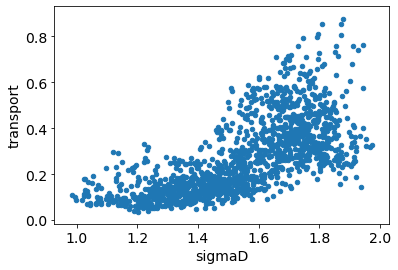

In [98]:
newds = pd.DataFrame({'sigmaD': densityforcing, 'transport': deep_flux/depthwidth})
newds.plot('sigmaD', 'transport', 'scatter')
newds.corr()

,sigmaD,transport
sigmaD,1.000000,0.822117
transport,0.822117,1.000000


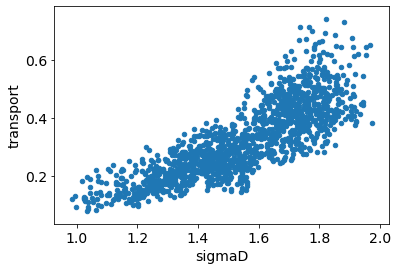

In [99]:
newds = pd.DataFrame({'sigmaD': densityforcing, 'transport': shallow_flux/depthwidth})
newds.plot('sigmaD', 'transport', 'scatter')
newds.corr()

# Wind #

In [368]:
wind = pd.read_csv('day_avg_wind.csv', index_col=0)
wind.index = pd.to_datetime(wind.index, format="%Y-%m-%d")
#low_pass_wind = pd.rolling_mean(day_avg_wind_pd, 4, center=True)

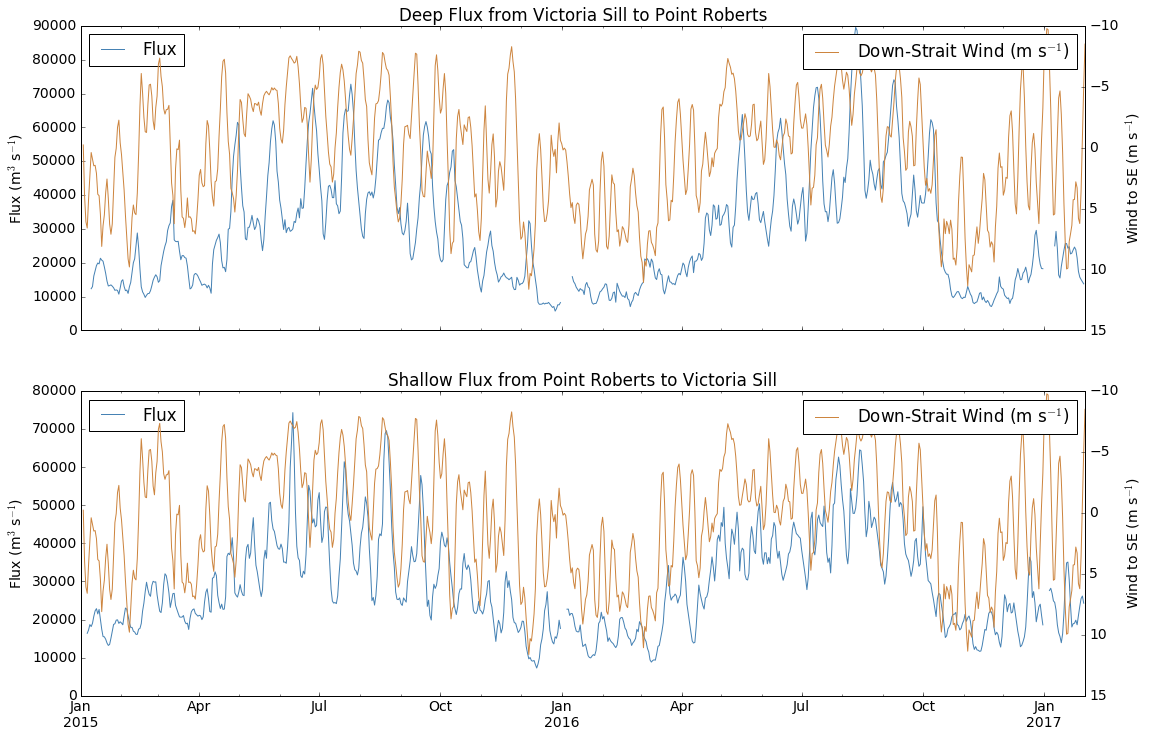

In [373]:
fig, ax = plt.subplots(2, 1, figsize=(18, 12))
ax[0].set_title("Deep Flux from Victoria Sill to Point Roberts")
deep_flux_2015.plot(ax=ax[0], y='transport', label="Flux", color='steelblue')
deep_flux_2016.plot(ax=ax[0], y='transport', label="", color='steelblue')
deep_flux_2017.plot(ax=ax[0], y='transport', label="", color='steelblue')
ax[1].set_title("Shallow Flux from Point Roberts to Victoria Sill")
shallow_flux_2015.plot(ax=ax[1], y='transport', label="Flux", color='steelblue')
shallow_flux_2016.plot(ax=ax[1], y='transport', label="", color='steelblue')
shallow_flux_2017.plot(ax=ax[1], y='transport', label="", color='steelblue')
for ax in [ax[0], ax[1]]:
    ax2 = ax.twinx()
    ax.set_ylabel('Flux (m$^3$ s$^{-1}$)')
    wind.rolling(window=4, center=True).mean().plot(ax=ax2, y='wind', legend=False, label='Down-Strait Wind (m s$^{-1}$)',  color = 'peru')
    ax.set_xlim(datetime.datetime(2015, 1, 1), datetime.datetime(2017, 2, 1))
    ax2.set_ylabel('Wind to SE (m s$^{-1}$)')
    ax2.invert_yaxis()
    ax.legend(loc='upper left')
    ax2.legend(loc='upper right')

,sigmaD,transport,wind
sigmaD,1.000000,0.723902,-0.579269
transport,0.723902,1.000000,-0.349371
wind,-0.579269,-0.349371,1.000000


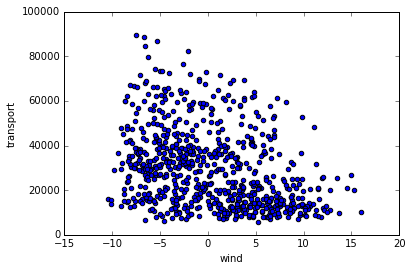

In [453]:
newds2 = pd.DataFrame({'sigmaD': newsa[:762], 'wind': wind.wind[:762], 'transport': newsb[:762]})
newds2.plot('wind', 'transport', 'scatter')
newds2.corr()

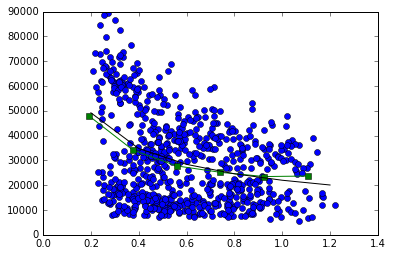

In [516]:
length = 731
newds3 = pd.DataFrame({'sigmaD': newsa[:length], 
                       'wind': wind.wind[:length], 
                       'tides': low_pass_tide.uVelocity[:length], 
                       'ratio' : newsa[:length]/low_pass_tide.uVelocity[:length],
                       'transport': newsb[:length]})
plt.plot(newds3.set_index('tides').transport, 'o')
bins = np.linspace(0.1, 1.2, 7)
plot_centers = (bins [:-1] + bins[1:])/2
group = newds3.groupby(pd.cut(newds3.tides, bins))
plot_values = group.transport.mean()
plt.plot(plot_centers, plot_values, 's-')
#newds3.plot.hexbin('tides', 'transport', gridsize=10)
plt.plot(np.arange(0.2, 1.4, 0.2), 22000./np.sqrt(np.arange(0.2, 1.4, 0.2)), 'k')

In [461]:
newds3.transport[365:370]

time
2016-01-01   NaN
2016-01-02   NaN
2016-01-03   NaN
2016-01-04   NaN
2016-01-05   NaN
Freq: D, Name: transport, dtype: float64

In [473]:
import statsmodels.api as sm
y = newds3.transport[8:365]
x = newds3[['ratio', 'wind']][8:365]
x = sm.add_constant(x)
model11 = sm.OLS(y, x).fit()
model11.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              transport   R-squared:                       0.560
Model:                            OLS   Adj. R-squared:                  0.558
Method:                 Least Squares   F-statistic:                     225.3
Date:                Wed, 05 Sep 2018   Prob (F-statistic):           7.65e-64
Time:                        17:47:18   Log-Likelihood:                -3824.3
No. Observations:                 357   AIC:                             7655.
Df Residuals:                     354   BIC:                             7666.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const       5175.0744   1324.126      3.908      0.000      2570.933  7779.216
ratio         50.5209      2.465     20.494      0.000        45.673    55.369
wind        -277.3991    105.241     -2.636      0.009      -484.375   -70.423
==============================================================================
Omnibus:                       16.843   Durbin-Watson:                   0.172
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                7.333
Skew:                           0.026   Prob(JB):                       0.0256
Kurtosis:                       2.300   Cond. No.                     1.24e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.24e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [476]:
y = newds3.transport[8:365]
x = newds3[['ratio']][8:365]
x = sm.add_constant(x)
model11 = sm.OLS(y, x).fit()
model11.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              transport   R-squared:                       0.551
Model:                            OLS   Adj. R-squared:                  0.550
Method:                 Least Squares   F-statistic:                     436.4
Date:                Wed, 05 Sep 2018   Prob (F-statistic):           9.09e-64
Time:                        17:51:47   Log-Likelihood:                -3827.8
No. Observations:                 357   AIC:                             7660.
Df Residuals:                     355   BIC:                             7667.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const       4844.2635   1329.161      3.645      0.000      2230.244  7458.283
ratio         51.4230      2.462     20.889      0.000        46.582    56.264
==============================================================================
Omnibus:                       16.673   Durbin-Watson:                   0.156
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                7.359
Skew:                           0.048   Prob(JB):                       0.0252
Kurtosis:                       2.303   Cond. No.                     1.23e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.23e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [475]:
y = newds3.transport[8:365]
x = newds3[['sigmaD', 'tides', 'wind']][8:365]
x = sm.add_constant(x)
model11 = sm.OLS(y, x).fit()
model11.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              transport   R-squared:                       0.618
Model:                            OLS   Adj. R-squared:                  0.615
Method:                 Least Squares   F-statistic:                     190.2
Date:                Wed, 05 Sep 2018   Prob (F-statistic):           2.19e-73
Time:                        17:49:50   Log-Likelihood:                -3799.2
No. Observations:                 357   AIC:                             7606.
Df Residuals:                     353   BIC:                             7622.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const      -3042.1559   2892.291     -1.052      0.294     -8730.445  2646.133
sigmaD       202.1803     10.244     19.737      0.000       182.034   222.327
tides      -2.835e+04   2296.257    -12.344      0.000     -3.29e+04 -2.38e+04
wind         490.2362    115.314      4.251      0.000       263.446   717.026
==============================================================================
Omnibus:                        5.936   Durbin-Watson:                   0.203
Prob(Omnibus):                  0.051   Jarque-Bera (JB):                5.238
Skew:                           0.226   Prob(JB):                       0.0729
Kurtosis:                       2.615   Cond. No.                     1.51e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.51e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

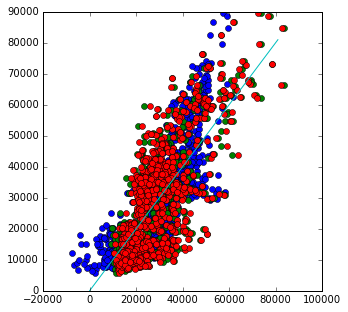

In [477]:
fig, ax = plt.subplots(1, 1, figsize=(5,5))
ax.plot(-3042.16+ 202.18*newds3.sigmaD 
         - 2.835e4*newds3.tides 
         + 490.24*newds3.wind, newds3.transport, 'o')
ax.plot(5175.1 + 50.52*newds3.ratio -277.4*newds3.wind, newds3.transport, 'o')
ax.plot(4844.3 + 51.42*newds3.ratio, newds3.transport, 'o')
ax.plot(range(0,90000, 9000), range(0, 90000,9000))